In [ ]:
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 991.0 kB/s eta 0:00:00


In [ ]:
import gdown
import os
from loguru import logger
import loguru
import zipfile

def clone_data():
    gg_drive_url = 'https://drive.google.com/uc?id=1jYxSQV5QVDTalFDbVSDBr1I4SPB-FTVb'
    output = 'data.zip'

    if (os.path.exists('./data')):
        logger.info('Data is already found in ./data, no action is needed.')
        return

    if (not os.path.exists(output)):
        logger.info('Downloading data from Google Drive...')
        gdown.download(gg_drive_url, output, quiet=False)
        logger.info('Data is downloaded.')
    else:
        logger.info('Data is already downloaded.')

    logger.info('Extracting data...')
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()
    logger.info('Data is extracted into ./data')
    os.remove(output)
clone_data()

2023-12-10 17:28:03.947 | INFO     | __main__:clone_data:16 - Downloading data from Google Drive...
Downloading...
From: https://drive.google.com/uc?id=1jYxSQV5QVDTalFDbVSDBr1I4SPB-FTVb
To: /content/data.zip
100%|██████████| 13.9M/13.9M [00:00<00:00, 122MB/s]
2023-12-10 17:28:08.013 | INFO     | __main__:clone_data:18 - Data is downloaded.
2023-12-10 17:28:08.015 | INFO     | __main__:clone_data:22 - Extracting data...
2023-12-10 17:28:08.670 | INFO     | __main__:clone_data:25 - Data is extracted into ./data


### Model

Model structure: CNN

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
import time

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, 10)

        # initialize the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Data processing

In [ ]:
def load_data():
    data_path = {
        'train': './data/csvTrainImages 60k x 784.csv',
        'test': './data/csvTestImages 10k x 784.csv',
        'train_label': './data/csvTrainLabel 60k x 1.csv',
        'test_label': './data/csvTestLabel 10k x 1.csv'
    }
    # Read the data as Tensor
    # Only use 5k of them for training
    indices = np.random.choice(60000, 5000)
    X_train = torch.Tensor(np.loadtxt(data_path['train'], delimiter=',')[indices])
    y_train = torch.Tensor(np.loadtxt(data_path['train_label'], delimiter=',')[indices])
    X_test = torch.Tensor(np.loadtxt(data_path['test'], delimiter=','))
    y_test = torch.Tensor(np.loadtxt(data_path['test_label'], delimiter=','))
    # Reshape the data
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
    # Convert the labels to long
    y_train = y_train.long()
    y_test = y_test.long()
    return X_train, y_train, X_test, y_test

### Model evaluation

In [ ]:
def evaluate(model, X_test, y_test, test_size = -1):
    if (test_size != -1):
        # Choose test_size of the test data to evaluate
        indices = np.random.choice(len(X_test), test_size)
        X_test = X_test[indices]
        y_test = y_test[indices]
    # Compute the accuracy
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / len(y_test)
    return accuracy

### SGD training

#### Trainer

In [ ]:
def train(model, loader, epochs=2, lr=1e-3, accuracy_refresh_rate=300):
    # save the current timer
    start_time = time.time()
    # use criterion as categorical cross entropy loss
    criterion = nn.CrossEntropyLoss()
    loguru.logger.debug('Entering training process...')
    logs = []
    for epoch in range(epochs):
        loguru.logger.debug('Entering epoch {}...'.format(epoch))
        model.train()
        cnt = 1
        tqdm._instances.clear()
        accuracy = 0
        progress_bar = tqdm(enumerate(loader, 0), unit="batch", total=len(loader))
        for _,data in progress_bar:
            cnt += 1
            X, y = data
            X, y = Variable(X), Variable(y)
            outputs = model(X)
            # Compute loss
            try:
                y = torch.Tensor([y])
                y = y.long()
            except:
                pass
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # Update parameter
            with torch.no_grad():
                for para in model.parameters():
                    para.data.sub_(lr * para.grad.data)

            if (cnt % accuracy_refresh_rate == 0):
                accuracy = evaluate(model, X_train, y_train, test_size=300)
                logs.append({
                    'epoch': epoch,
                    'iteration': cnt + epoch * len(loader),
                    'loss': loss.item(),
                    'accuracy': accuracy,
                    'time': time.time() - start_time
                })
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy)
            progress_bar.update()
            model.zero_grad()
    return logs

#### Training process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

def sgd_train(refresh_rate):
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    # Create the model
    model = Model()

    # print the number of parameters
    loguru.logger.debug('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))

    # Train the model
    logs = train(model, train_loader, accuracy_refresh_rate=refresh_rate)

    # Evaluate the model
    accuracy = evaluate(model, X_test, y_test)
    loguru.logger.success('Test accuracy: {}'.format(accuracy))
    train_accuracy = evaluate(model, X_train, y_train)
    loguru.logger.success('Train accuracy: {}'.format(train_accuracy))
    return logs, train_accuracy, accuracy
sgd_logs, sgd_train_accuracy, sgd_test_accuracy = sgd_train(30)

2023-12-10 14:44:18.311 | DEBUG    | __main__:sgd_train:16 - Number of parameters: 29034
2023-12-10 14:44:18.317 | DEBUG    | __main__:train:6 - Entering training process...
2023-12-10 14:44:18.319 | DEBUG    | __main__:train:9 - Entering epoch 0...
100%|██████████| 5000/5000 [01:03<00:00, 78.27batch/s, accuracy=0.97, loss=0.589]
2023-12-10 14:45:22.213 | DEBUG    | __main__:train:9 - Entering epoch 1...
100%|██████████| 5000/5000 [00:59<00:00, 84.00batch/s, accuracy=0.973, loss=0.00201]
2023-12-10 14:46:28.290 | SUCCESS  | __main__:sgd_train:23 - Test accuracy: 0.9568
2023-12-10 14:46:30.748 | SUCCESS  | __main__:sgd_train:25 - Train accuracy: 0.9716


### GD training

In [ ]:
def gd_train():
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    # Note the difference in batch size
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=X_train.shape[0], shuffle=True)

    # Create the model
    model = Model()

    # print the number of parameters
    loguru.logger.debug('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))

    # Train the model
    logs = train(model, train_loader, epochs=150, lr=1e-2, accuracy_refresh_rate=1)

    # Evaluate the model
    accuracy = evaluate(model, X_test, y_test)
    loguru.logger.success('Accuracy: {}'.format(accuracy))
    train_accuracy = evaluate(model, X_train, y_train)
    loguru.logger.success('Train accuracy: {}'.format(train_accuracy))
    return logs, train_accuracy, accuracy

gd_logs, gd_train_accuracy, gd_test_accuracy = gd_train()

2023-12-10 13:58:16.542 | DEBUG    | __main__:gd_train:10 - Number of parameters: 29034
2023-12-10 13:58:16.544 | DEBUG    | __main__:train:6 - Entering training process...
2023-12-10 13:58:16.546 | DEBUG    | __main__:train:9 - Entering epoch 0...
100%|██████████| 1/1 [00:05<00:00,  5.51s/batch, accuracy=0.167, loss=2.93]
2023-12-10 13:58:22.065 | DEBUG    | __main__:train:9 - Entering epoch 1...
100%|██████████| 1/1 [00:06<00:00,  6.63s/batch, accuracy=0.26, loss=2.35]
2023-12-10 13:58:28.707 | DEBUG    | __main__:train:9 - Entering epoch 2...
100%|██████████| 1/1 [00:05<00:00,  5.87s/batch, accuracy=0.383, loss=2.02]
2023-12-10 13:58:34.587 | DEBUG    | __main__:train:9 - Entering epoch 3...
100%|██████████| 1/1 [00:06<00:00,  6.64s/batch, accuracy=0.487, loss=1.8]
2023-12-10 13:58:41.241 | DEBUG    | __main__:train:9 - Entering epoch 4...
100%|██████████| 1/1 [00:05<00:00,  5.65s/batch, accuracy=0.477, loss=1.63]
2023-12-10 13:58:46.900 | DEBUG    | __main__:train:9 - Entering epoc

### SAGA Training

#### Data Preparation


In [ ]:
n_samples = X_train.shape[0]
n_epoch = 2
random_iter = np.random.randint(0, n_samples, n_samples * n_epoch)
n_samples, random_iter.shape

In [ ]:
class CustomRandomSampler:
    """Samples elements randomly, one data sample can appear multiple times within one epoch

    Arguments:
        data_source (Dataset): dataset to sample from
        iter_list: order of the data samples to take
    """
    def __init__(self, data_source, iter_list):
        self.data_source = data_source
        self.iter_list = torch.LongTensor(iter_list)

    def __iter__(self):
        return iter(self.iter_list)

    def __len__(self):
        return len(self.iter_list)

In [ ]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
sampler = CustomRandomSampler(dataset, random_iter)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=sampler, shuffle=False)

#### SAGA Trainer

In [ ]:
import copy

def initialize_para(nn, val):
	for para in nn.parameters():
		para.data.fill_(val)
	return nn

def saga_trainer(model, loader, n_samples, iter_list, epochs=1, lr=1e-3, accuracy_refresh_rate=300):
    # use criterion as categorical cross entropy loss
    criterion = nn.CrossEntropyLoss()
    mean_grad = initialize_para(copy.deepcopy(model), 0)
    # This below is memory costly
    prev_stoc_grad = [initialize_para(copy.deepcopy(model), 0) for i in range(n_samples)]
    # save the current timer
    start_time = time.time()
    loguru.logger.debug('Entering training process...')
    logs = []
    for epoch in range(epochs):
        loguru.logger.debug('Entering epoch {}...'.format(epoch))
        model.train()
        cnt = 1
        tqdm._instances.clear()
        accuracy = 0
        progress_bar = tqdm(enumerate(loader, 0), unit="batch", total=len(loader))
        for i,data in progress_bar:
            cnt += 1
            X, y = data
            X, y = Variable(X), Variable(y)
            outputs = model(X)
            y = torch.Tensor([y])
            y = y.long()
            loss = criterion(outputs, y)
            loss.backward() # Compute derivative for this data point
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # Merging with previous
            i_data = iter_list[i]

            for para, para_prev, para_mean in zip(model.parameters(), prev_stoc_grad[i_data].parameters(), mean_grad.parameters()):
                saga_update = para.grad.data - para_prev.data + para_mean.data
                para_mean.data += (1./n_samples) * (para.grad.data - para_prev.data) #update mean
                para_prev.data = para.grad.data.clone() # update previous grad
                para.data.sub_(saga_update * lr)

            if (cnt % accuracy_refresh_rate == 0):
                accuracy = evaluate(model, X_train, y_train, test_size=300)
                logs.append({
                    'epoch': epoch,
                    'iteration': cnt + epoch * len(loader),
                    'loss': loss.item(),
                    'accuracy': accuracy,
                    'time': time.time() - start_time
                })
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy)
            progress_bar.update()
            model.zero_grad()
    return logs

#### Training process

In [ ]:
def saga_train(refresh_rate=300):
    # Create the model
    model = Model()

    # print the number of parameters
    loguru.logger.debug('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))

    # Train the model
    logs = saga_trainer(model, train_loader, n_samples, random_iter, accuracy_refresh_rate=refresh_rate)

    # Evaluate the model
    accuracy = evaluate(model, X_test, y_test)
    loguru.logger.success('Accuracy: {}'.format(accuracy))
    train_accuracy = evaluate(model, X_train, y_train)
    loguru.logger.success('Train accuracy: {}'.format(train_accuracy))
    return logs, train_accuracy, accuracy
saga_logs, saga_train_accuracy, saga_test_accuracy = saga_train(30)

2023-12-10 14:47:02.685 | DEBUG    | __main__:saga_train:6 - Number of parameters: 29034
2023-12-10 14:47:14.562 | DEBUG    | __main__:saga_trainer:16 - Entering training process...
2023-12-10 14:47:14.564 | DEBUG    | __main__:saga_trainer:19 - Entering epoch 0...
100%|██████████| 10000/10000 [02:18<00:00, 72.28batch/s, accuracy=0.977, loss=0.00566]
2023-12-10 14:49:38.271 | SUCCESS  | __main__:saga_train:13 - Accuracy: 0.9581
2023-12-10 14:49:41.024 | SUCCESS  | __main__:saga_train:15 - Train accuracy: 0.9656


### Some statistics


#### Loss graphs by number of iterations


For SGD and SAGA, the loss values

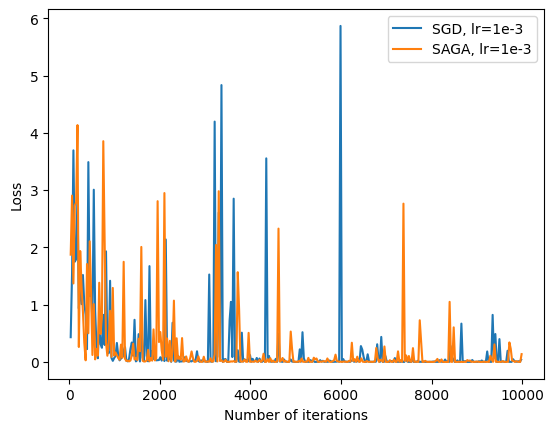

In [ ]:
# prompt: Draw the loss graphs (loss_values/iterations) from sgd_logs, gd_logs, and saga_logs

import matplotlib.pyplot as plt

def plot_loss(logs, name):
    plt.plot([log['iteration'] for log in logs], [log['loss'] for log in logs], label=name)

plot_loss(sgd_logs, 'SGD, lr=1e-3')
plot_loss(saga_logs, 'SAGA, lr=1e-3')

plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Eyeballing: SAGA is less fluctuating

#### Loss graphs by time

In [ ]:
sgd_logs, sgd_train_accuracy, sgd_test_accuracy = sgd_train(300)

2023-12-10 14:53:59.758 | DEBUG    | __main__:sgd_train:16 - Number of parameters: 29034
2023-12-10 14:53:59.763 | DEBUG    | __main__:train:6 - Entering training process...
2023-12-10 14:53:59.767 | DEBUG    | __main__:train:9 - Entering epoch 0...
100%|██████████| 5000/5000 [00:40<00:00, 123.69batch/s, accuracy=0.967, loss=0.00499]
2023-12-10 14:54:40.203 | DEBUG    | __main__:train:9 - Entering epoch 1...
100%|██████████| 5000/5000 [00:40<00:00, 123.06batch/s, accuracy=0.97, loss=0.000863]
2023-12-10 14:55:25.933 | SUCCESS  | __main__:sgd_train:23 - Test accuracy: 0.9553
2023-12-10 14:55:28.392 | SUCCESS  | __main__:sgd_train:25 - Train accuracy: 0.9702


In [ ]:
saga_logs, saga_train_accuracy, saga_test_accuracy = saga_train(300)

2023-12-10 15:10:48.708 | DEBUG    | __main__:saga_train:6 - Number of parameters: 29034
2023-12-10 15:10:59.624 | DEBUG    | __main__:saga_trainer:16 - Entering training process...
2023-12-10 15:10:59.626 | DEBUG    | __main__:saga_trainer:19 - Entering epoch 0...
100%|██████████| 10000/10000 [01:37<00:00, 102.11batch/s, accuracy=0.973, loss=0.00245]
2023-12-10 15:12:43.775 | SUCCESS  | __main__:saga_train:13 - Accuracy: 0.9541
2023-12-10 15:12:47.138 | SUCCESS  | __main__:saga_train:15 - Train accuracy: 0.9676


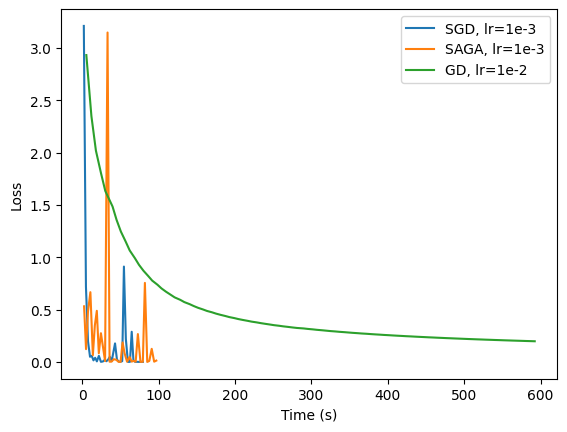

In [ ]:
# prompt: Compare loss values by time between sgd_logs, saga_logs, and gd_logs

def plot_loss_by_time(logs, name):
    plt.plot([log['time'] for log in logs], [log['loss'] for log in logs], label=name)

plot_loss_by_time(sgd_logs, 'SGD, lr=1e-3')
plot_loss_by_time(saga_logs, 'SAGA, lr=1e-3')
plot_loss_by_time(gd_logs, 'GD, lr=1e-2')

plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Accuracy by time

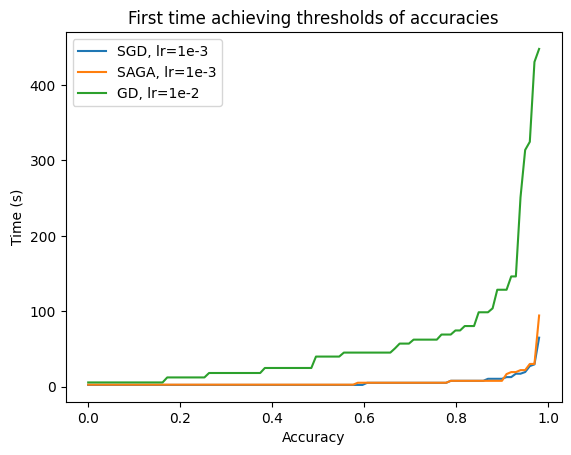

In [ ]:
# prompt: Plot the first time that each optimizer (GD, SGD, SAGA) achieved each accuracy from 0% to 100%, x axis is accuracy, y axis is time

import numpy as np
import matplotlib.pyplot as plt

def get_time_by_accuracy(logs, accuracy):
    for log in logs:
        if log['accuracy'] >= accuracy:
            return log['time']
    return None

def plot_accuracy_by_time(logs, name):
    accuracies = np.linspace(0, 1, 100)
    times = [get_time_by_accuracy(logs, accuracy) for accuracy in accuracies]
    plt.plot(accuracies, times, label=name)

plot_accuracy_by_time(sgd_logs, 'SGD, lr=1e-3')
plot_accuracy_by_time(saga_logs, 'SAGA, lr=1e-3')
plot_accuracy_by_time(gd_logs, 'GD, lr=1e-2')

plt.xlabel('Accuracy')
plt.ylabel('Time (s)')
plt.legend()
plt.title('First time achieving thresholds of accuracies')
plt.show()



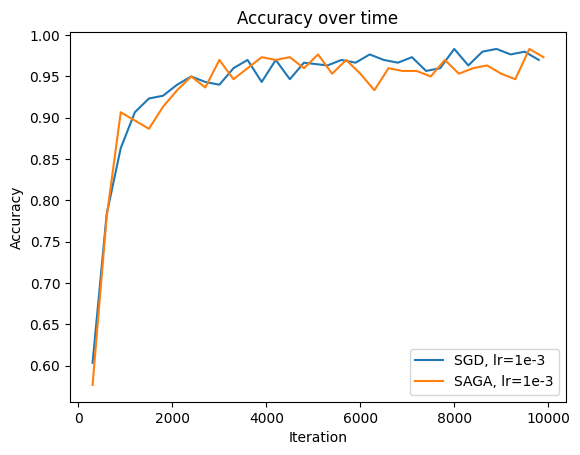

In [ ]:
# prompt: Plot the accuracy over time between SAGA and SGD

def plot_accuracy_over_time2(logs, name):
    plt.plot([log['iteration'] for log in logs], [log['accuracy'] for log in logs], label=name)

plot_accuracy_over_time2(sgd_logs, 'SGD, lr=1e-3')
plot_accuracy_over_time2(saga_logs, 'SAGA, lr=1e-3')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over time')
plt.show()



#### Variance of Gradient

In [ ]:
checkpoints = np.arange(1, 10000, 1000)
checkpoints = np.append(checkpoints, 10000)
checkpoints

array([    1,  1001,  2001,  3001,  4001,  5001,  6001,  7001,  8001,
        9001, 10000])

##### Modified trainer for SGD to compute variance

In [152]:
variances_sgd = []
def train(model, loader, epochs=2, lr=1e-3, accuracy_refresh_rate=300):
    # save the current timer
    start_time = time.time()
    # use criterion as categorical cross entropy loss
    criterion = nn.CrossEntropyLoss()
    loguru.logger.debug('Entering training process...')
    logs = []
    for epoch in range(epochs):
        loguru.logger.debug('Entering epoch {}...'.format(epoch))
        model.train()
        cnt = 0
        tqdm._instances.clear()
        accuracy = 0
        progress_bar = tqdm(enumerate(loader, 0), unit="batch", total=len(loader))
        for _,data in progress_bar:
            cnt += 1
            X, y = data
            X, y = Variable(X), Variable(y)
            outputs = model(X)
            # Compute loss
            try:
                y = torch.Tensor([y])
                y = y.long()
            except:
                pass
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # Update parameter
            with torch.no_grad():
                for para in model.parameters():
                    para.data.sub_(lr * para.grad.data)

            if (cnt % accuracy_refresh_rate == 0):
                accuracy = evaluate(model, X_train, y_train, test_size=300)
                logs.append({
                    'epoch': epoch,
                    'iteration': cnt + epoch * len(loader),
                    'loss': loss.item(),
                    'accuracy': accuracy,
                    'time': time.time() - start_time
                })
            if (cnt + epoch * len(loader) in checkpoints):
                loguru.logger.debug('Evaluating variance at checkpoint {}...'.format(cnt + epoch * len(loader)))
                loguru.logger.debug('Evaluating full gradient')
                true_grad = []
                model.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                for params in model.parameters():
                    true_grad.append(copy.deepcopy(params.grad))
                    break
                true_grad = torch.mean(torch.stack(true_grad, 0), dim=0)
                grad_history = []
                for _, data in enumerate(loader):
                    X, y = data
                    X, y = Variable(X), Variable(y)
                    model.zero_grad()
                    outputs = model(X)
                    loss = criterion(outputs, y)
                    loss.backward()
                    for params in model.parameters():
                        grad_history.append(copy.deepcopy(params.grad))
                        break
                grad_history = torch.stack(grad_history, 0)
                variance = torch.mean(torch.mean((grad_history - true_grad)**2, dim=0))
                variances_sgd.append(variance)
                loguru.logger.success('Variance: {}'.format(variance))
                del grad_history
                del true_grad

            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy)
            progress_bar.update()
            model.zero_grad()
    return logs

In [153]:
sgd_logs, sgd_train_accuracy, sgd_test_accuracy = sgd_train(300)

2023-12-10 18:54:39.789 | DEBUG    | __main__:sgd_train:16 - Number of parameters: 29034
2023-12-10 18:54:39.794 | DEBUG    | __main__:train:7 - Entering training process...
2023-12-10 18:54:39.797 | DEBUG    | __main__:train:10 - Entering epoch 0...
  0%|          | 0/5000 [00:00<?, ?batch/s]2023-12-10 18:54:39.815 | DEBUG    | __main__:train:46 - Evaluating variance at checkpoint 1...
2023-12-10 18:54:39.817 | DEBUG    | __main__:train:47 - Evaluating full gradient
2023-12-10 18:55:01.910 | SUCCESS  | __main__:train:71 - Variance: 0.06299468129873276
 23%|██▎       | 1168/5000 [00:30<00:34, 111.53batch/s, accuracy=0.88, loss=0.0211]2023-12-10 18:55:10.280 | DEBUG    | __main__:train:46 - Evaluating variance at checkpoint 1001...
2023-12-10 18:55:10.283 | DEBUG    | __main__:train:47 - Evaluating full gradient
2023-12-10 18:55:31.903 | SUCCESS  | __main__:train:71 - Variance: 0.01188935898244381
 45%|████▍     | 2232/5000 [01:00<00:27, 99.44batch/s, accuracy=0.94, loss=0.00336]2023-12

##### Modified trainer for SAGA to compute variance

In [156]:
variances_saga = []
def saga_trainer(model, loader, n_samples, iter_list, epochs=1, lr=1e-3, accuracy_refresh_rate=300):
    # use criterion as categorical cross entropy loss
    criterion = nn.CrossEntropyLoss()
    mean_grad = initialize_para(copy.deepcopy(model), 0)
    # This below is memory costly
    prev_stoc_grad = [initialize_para(copy.deepcopy(model), 0) for i in range(n_samples)]
    # save the current timer
    start_time = time.time()
    loguru.logger.debug('Entering training process...')
    logs = []
    for epoch in range(epochs):
        loguru.logger.debug('Entering epoch {}...'.format(epoch))
        model.train()
        cnt = 0
        tqdm._instances.clear()
        accuracy = 0
        progress_bar = tqdm(enumerate(loader, 0), unit="batch", total=len(loader))
        for i,data in progress_bar:
            cnt += 1
            X, y = data
            X, y = Variable(X), Variable(y)
            outputs = model(X)
            y = torch.Tensor([y])
            y = y.long()
            loss = criterion(outputs, y)
            loss.backward() # Compute derivative for this data point
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # Merging with previous
            i_data = iter_list[i]

            for para, para_prev, para_mean in zip(model.parameters(), prev_stoc_grad[i_data].parameters(), mean_grad.parameters()):
                saga_update = para.grad.data - para_prev.data + para_mean.data
                para_mean.data += (1./n_samples) * (para.grad.data - para_prev.data) #update mean
                para_prev.data = para.grad.data.clone() # update previous grad
                para.data.sub_(saga_update * lr)

            if (cnt % accuracy_refresh_rate == 0):
                accuracy = evaluate(model, X_train, y_train, test_size=300)
                logs.append({
                    'epoch': epoch,
                    'iteration': cnt + epoch * len(loader),
                    'loss': loss.item(),
                    'accuracy': accuracy,
                    'time': time.time() - start_time
                })
            if (cnt + epoch * len(loader) in checkpoints):
                loguru.logger.debug('Evaluating variance at checkpoint {}...'.format(cnt + epoch * len(loader)))
                loguru.logger.debug('Evaluating full gradient')
                true_grad = []
                model.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                for params in model.parameters():
                    true_grad.append(copy.deepcopy(params.grad))
                    break
                true_grad = torch.mean(torch.stack(true_grad, 0), dim=0)
                grad_history = []
                for i, data in enumerate(loader):
                    X, y = data
                    X, y = Variable(X), Variable(y)
                    model.zero_grad()
                    outputs = model(X)
                    loss = criterion(outputs, y)
                    loss.backward()
                    i_data = iter_list[i]
                    for para, para_prev, para_mean in zip(model.parameters(), prev_stoc_grad[i_data].parameters(), mean_grad.parameters()):
                        saga_update = para.grad.data - para_prev.data + para_mean.data
                        grad_history.append(copy.deepcopy(saga_update))
                        break


                grad_history = torch.stack(grad_history, 0)
                variance = torch.mean(torch.mean((grad_history - true_grad)**2, dim=0))
                variances_saga.append(variance)
                loguru.logger.success('Variance: {}'.format(variance))
                del grad_history
                del true_grad

            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy)
            progress_bar.update()
            model.zero_grad()
    return logs

In [157]:
saga_logs, saga_train_accuracy, saga_test_accuracy = saga_train(300)

2023-12-10 19:06:35.896 | DEBUG    | __main__:saga_train:6 - Number of parameters: 29034
2023-12-10 19:06:49.226 | DEBUG    | __main__:saga_trainer:10 - Entering training process...
2023-12-10 19:06:49.228 | DEBUG    | __main__:saga_trainer:13 - Entering epoch 0...
  0%|          | 0/10000 [00:00<?, ?batch/s]2023-12-10 19:06:49.262 | DEBUG    | __main__:saga_trainer:49 - Evaluating variance at checkpoint 1...
2023-12-10 19:06:49.266 | DEBUG    | __main__:saga_trainer:50 - Evaluating full gradient
2023-12-10 19:07:33.299 | SUCCESS  | __main__:saga_trainer:78 - Variance: 0.05002965033054352
 11%|█▏        | 1141/10000 [00:55<01:25, 103.17batch/s, accuracy=0.837, loss=0.11] 2023-12-10 19:07:44.713 | DEBUG    | __main__:saga_trainer:49 - Evaluating variance at checkpoint 1001...
2023-12-10 19:07:44.715 | DEBUG    | __main__:saga_trainer:50 - Evaluating full gradient
2023-12-10 19:08:25.331 | SUCCESS  | __main__:saga_trainer:78 - Variance: 0.010354370810091496
 22%|██▏       | 2195/10000 [0

##### Variance plot

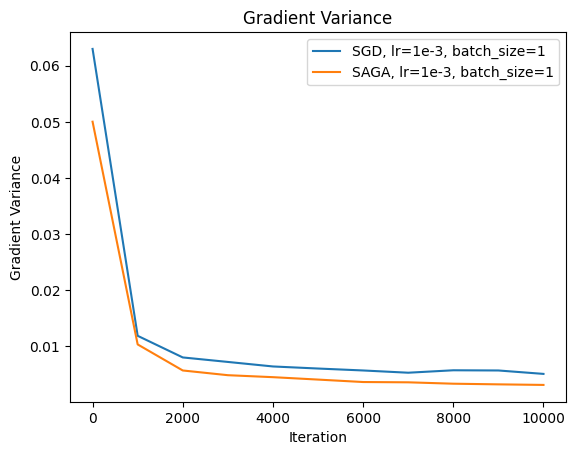

In [161]:
# prompt: From variances_sgd and variances_saga, plot a plot with x axis is checkpoints

plt.plot(checkpoints, variances_sgd, label='SGD, lr=1e-3, batch_size=1')
plt.plot(checkpoints, variances_saga, label='SAGA, lr=1e-3, batch_size=1')
plt.title('Gradient Variance')
plt.xlabel('Iteration')
plt.ylabel('Gradient Variance')
plt.legend()
plt.show()
